## What is ETL

ETL are the three different processes needed to pull databases from one database and place it in another database.

### E - Extract
Process of reading data from a database. In this stage, the data is collected, often from multiple and different types of sources.

In our case, we will be extracting data from our own computers. For simplicity sakes, one of our folders on our computers will be the "database" and we will traverse through all the files in this folder and find our files we need to transform. 

### T - Transform
Process of converting the extracted data from its previous form into the form it needs to be in so that it can be placed into another database. Transformation occurs by using rules or lookup tables or by combining the data with other data.

In terms of transforming the data, we will load the data into python and convert it into a string in python and append a highlight section to the file

### L - Load
Process of writing the data into the target database

This is the part where we write the file into a .txt file in a different directory (database 2).

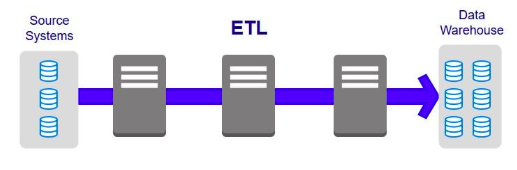

## How are we using ETL

We are going to be using ETL to transform the raw data from the archives database into a normalized format so that it can be used to train a model for machine learning. 

Essentially, we are transforming a bunch of types of files (pdf, excel, word) files into a more simpler '.txt' form. 

### Metadata

Once the files are collected into it's '.txt' form a 'highlight' section is appended to the end of the file. This highlight section is meant to summarize the data to train the machine learning model

### Why do we need to summarize the data for all these files?

The purpose of summarizing all these files is to be able to create "examples" for the machine learning model to understand how you summarize your data. So basically if you give it a new block of text without a summary, it will know how to summarize the new text based on the old examples you gave it.

## Installing packages

Below is code needed to perform ETL on the data. We will be using a python package called `textract`. Essentially this converts your files whether it be (pdf, word doc, excel) into strings in python. 

`textract` will be used in the transformation step<br>
`xlrd` will be used to interact with the excel files and is installed with textract

In [2]:
import sys

!{sys.executable} -m pip install textract

  Using cached https://files.pythonhosted.org/packages/0c/b0/8946fe3f9c2690c164aaa88dfd43b56347d3cdeac34124b988acd1aaa151/xlrd-1.0.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/af/a3/9e803f838b3eeb313d45d916d4387cda8572c92e1aafeb53fd43ddb5da2c/beautifulsoup4-4.5.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ce/c7/ab6cd0d00ddf8dc3b537cfb922f3f049f8018f38c88d71fd164f3acb8416/SpeechRecognition-3.6.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f0/0f/f965f1520e6ba24b63320919eecfbe3d03debd32402e0c61a08e8fa02d17/argcomplete-1.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7e/5c/605ca2daa5cf21c87690d8fe6ab05a6f2278c451f4ede6456dd26453f4bd/chardet-2.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c8/0a/b6723e1bc4c516cb687841499455a8505b44607ab535be01091c0f24f079/six-1.10.0-py2.py3-none-any.whl
spyder 3.3.2 requires pyqt5<5.10; python_version >=

## Extracting Data

Essentially extracting the file paths so you know where to look to transform the data

Create a list of file paths and metadata paths so you know where the files you want to look for:
 1. traverse through all the files in the desired directory<br>
 (https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python)
 2. check if the file is a proper file you want to convert by looking at the extension:<br>
 `if file_extension.lower() in accepted_file_ext:`
 3. check if the file is a metadata:<br>
 `if 'metadata' in curr_dir and file_extension.lower() in ['.xlsx', '.xls']:`
     

In [4]:
from os import listdir, walk
from os.path import join, splitext, basename

# path to the directory you want to extract (path to database)
mypath = '/Users/matt/Documents/OPS_Hackathon/RG 67-5'

# an empty list of the file paths of the files u want to transform
file_paths = []

# an empty list of the metadata paths
md_paths = []

# accepted file extensions from the files you are reading
accepted_file_ext =  ['.csv', '.doc', '.docx', '.eml', '.epub', '.gif', '.jpg', '.json', '.html', '.htm', '.mp3',
                    '.msg', '.odt', '.ogg', '.pdf', '.png', '.pptx', '.ps', '.rtf', '.tiff', '.tif', '.txt',
                    '.wav', '.xlsx', '.xls']
# Extract
# creates a list of all file paths

# (1) traverse through all the files in the desired directory
for (dirpath, dirnames, filenames) in walk(mypath):
    curr_dir = dirpath.split('/')[-1].lower()
    
    for file in filenames:
        filename, file_extension = splitext(file)
        
        # (2) checks if file has the proper extension 
        if file_extension.lower() in accepted_file_ext:
            
            # (3) check if the file is a meta data
            # adds the path to the data to a list
            if 'metadata' in curr_dir and file_extension.lower() in ['.xlsx', '.xls']:
                md_paths.append(join(dirpath, file))
            else:
                file_paths.append(join(dirpath, file))
                
# prints the list of file paths (delete comment to see the list of paths)
# print(file_paths)
# print(md_paths)

## Transforming and Loading (pt 1)

The two sections are grouped together because both are steps are closely linked together for this particular workflow. The `file_paths` and `md_paths` lists created earlier will be used to create a final .txt file with all the text and a description from the metadata.

Steps include:

1. Getting a list of descriptions from the metadata (example of excel file below)
    - loop through all the sheets within the excel file
    - find the column in first row that contains 'title' or 'description'
    - loops through all the items in that column and adds it to the description list
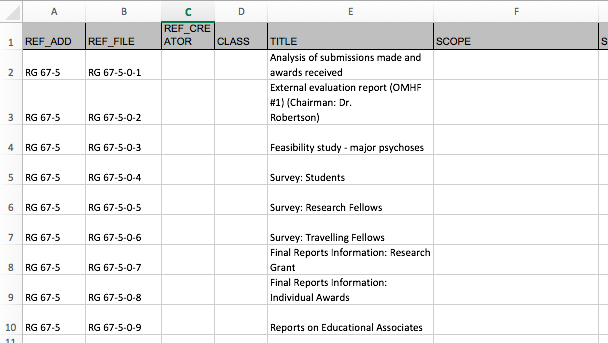

In [2]:
## Transforming data
import xlrd

## (1) getting a list of descriptions from the metadata
description_list = []
for md_path in md_paths:
    try:
        xlrd_obj = xlrd.open_workbook(md_path)
        
        # loops through all the sheets
        for sheet in xlrd_obj.sheets():
            row_count = 0
            
            # finds column in excel file that contains title or description info
            for header in sheet.row(0):
                str_hdr =  header.value.lower()
                if 'title' in str_hdr or 'description' in str_hdr:
                    break                
                row_count += 1
                
            # loops through the items in the column
            for item in sheet.col(row_count):
                str_item = str(item.value)
                description_list.append(item.value)
    except:
        print("Failed to read file: %s" % md_path)

# clears the title or description (clears first item in list)
description_list.pop(0)
print(description_list)



Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_metadata/RG 67-5 File list for ADD.xlsx
['Analysis of submissions made and awards received', 'External evaluation report (OMHF #1) (Chairman: Dr.\nRobertson)', 'Feasibility study - major psychoses', 'Survey: Students', 'Survey: Research Fellows', 'Survey: Travelling Fellows', 'Final Reports Information: Research Grant', 'Final Reports Information: Individual Awards', 'Reports on Educational Associates']


## Transforming and Loading (pt 2)

2. Convert files into text files (example output below)
    - create a filename for the file of the .txt
    - read file through `textract` into a string
    - check if file contains the highlight in metafile
    - create a .txt file in the `output_files` directory
    - write the text and highlight to the file
<br>![example_final_output.png](attachment:example_final_output.png)

### NOTE: There may be many files unable to be read and that's normal, because some files  that come from the database are corrupt and cannot be opened.

In [3]:
import textract

## (2) convert files into text files
for file_path in file_paths:
    
    # create a filename for the file of the .txt
    filename = basename(file_path) + ".txt"
    try:
        
        # read file through `textract` into a string
        text = textract.process(file_path)
        highlight = ''
        
        # check if file contains the highlight in metafile
        for descrip in description_list:
            if descrip in text:
                highlight = descrip
                break
        
        # create a .txt file in the `output_files` directory
        with open(join("output_files", filename), "w") as text_file:
            # write the text and highlight to the file
            text_file.write(text)
            text_file.write('\n\n\n@highlight\n\n%s' % highlight)
    except:
        print("Failed to read file: %s" % file_path)

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_metadata/RG 67-5_filelist.PDF
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2004/AnnualReport04-05.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2009/Chair_s report 2008-2009 (2).docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2009/French/Exemption from translation form v09May.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2009/French/French Language Annual Report.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2013/OMHF 2014 FS_fre-CA-final.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2013/ED Report/ED Draft1.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2014/Annual report 2014-2015.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2014/Chair Report 2014-2015.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Annual Reports/2014/ED report 2015.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-0

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2001-2017 Audited Financial Statements/Financial Statements March 31, 2017.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2003-2017 Misc/2007-08 GRANTS Commitment.xls
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2003-2017 Misc/Accrued Sal and Benefits 04.xls
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2003-2017 Misc/Adm Exp variance 2004.xls
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2003-2017 Misc/anita_sTrial Balance Work Sheets.xls
Failed to read file: /Users/matt/Doc

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2016-2017 Audit/Confirmation Letters/Receivable Confirmation - The Hospital for Sick Children.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2016-2017 Audit/Confirmation Letters/Receivable Confirmation - University of Ottawa.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2016-2017 Audit/Confirmation Letters/Receivable Confirmation - York University.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Audit/2016-2017 Audit/Draft statements/2017 OMHF Draft Financial Statements 06 14 17.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 in

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2009/AUG18 Final Bus Plan.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2009/Avison Edited.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2009/BUSINESS PLAN D1  V2 KJ to AG.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2009/BUSINESS PLAN D1  V3 KJ mods (3).doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2009/BUSINESS PLAN D1 0.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2012/2012-2014 BUS PLAN D1.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2012/2012-2014 BUS PLAN D1@2012-02-21T14_41_44.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2012/2012-2014 BUS PLAN D1@2012-02-21T17_10_42.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2012/2012-2016 BUSINESS PLAN (2).docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2012/2012-2016 BUSINESS PLAN.doc
Failed to read file: 

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2015/05192 OMHF 2015-16 Business Plan (10May16).doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2015/2013-2016 BUSINESS PLAN.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2015/APRIL 2015 DRAFT BUSINESS PLAN.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2015/BUSINESS PLAN 2015-2016.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Business Plans/2015/Grants and Fellowships MOHLTC _ OMHF.xls
Failed to read file: 

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Governance/Board Renewal/Chair job.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Governance/Board Renewal/Draft Board Prospect Letter.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Governance/Board Renewal/gill brown reappoint matthews.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Governance/Board Renewal/Gill reappoint 2013.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Governance/Board Renewal/Letter to David Caplan re Macmillan.doc
Failed to read file: /Users/ma

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2010/12 2010/DENIS DECEMBER 2010 MINUTES.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2011/06 2011/Agenda June 2.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2011/06 2011/~$enda June 2.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2011/08 2011/Calculating disbursments (2) (2).docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2011/08 2011/Disbursement Options.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2014/03 2014/5-Alliance Charter Dec 13th 2013 (2015_01_27 18_58_40 UTC).doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2014/03 2014/5-Research and Fellowships budgets 2013-2014.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2014/03 2014/6-Grant and fellowship budgets (2015_01_27 18_58_40 UTC).docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2014/03 2014/7-Fellowships report 2014-2015 (2015_01_27 18_58_40 UTC).xls
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governanc

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/01 2015/RANKNAME GRANTS 2015.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/01 2015/~$ail to awardees.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/01 2015/BOARD TELECONFERENCE JANUARY 2015/Budget Issue Final.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/01 2015/BOARD TELECONFERENCE JANUARY 2015/Minutes of Board Meeting Januart 28, 2015.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/03 2015/ag

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/09 2015/agenda 2015-09-03.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/09 2015/Holiday Inn September 3 2015.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/09 2015/Minutes June 04 2015 meeting REVISED Sept 3.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/09 2015/Minutes June 04 2015 meeting REVISED Sept 3.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2015/09 2015/Minutes June 04 2015 meeting.docx
Fai

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2016/06 2016/05. 2016 OMHF Approve Adjusting Entries.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2016/06 2016/05. 2016 OMHF Audit Planning Letter.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2016/06 2016/05. 2016 OMHF Draft Financial Statements.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2016/06 2016/05. 2016 OMHF Engagement Letter.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2016/06 2016/05. Fundraising  Plan to 

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2017/04 2017/5. Partnership Possibilities Update.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2017/04 2017/Minutes April 5 2017 Board Meeting.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2017/04 2017/OMHF April 5 2017 Board Meeting Agenda.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2017/05 2017/3. Mark Blumberg bio.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2017/05 2017/4. Minutes April 5 2017 Board Meeting.do

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2018/01 2018/Written Resolutions/OMHF-02-2018-second.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/2018/01 2018/Written Resolutions/Schedule A to written Resolution as of Jan 31, 2018 - Asset Transfer Agreement.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/Board Meeting Info/5-Research and Fellowships budgets 2013-2014.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Meetings/Board Meeting Info/average.xlsx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Gregory Brown/Letter to Matthews re Brown reappointment.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Heather Stuart/Heather Stuart - Congratulations.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Heather Stuart/Heather Stuart Reappointment Confirmation July 2017.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Heather Stuart/Heather Stuart Reappointment Request form April 2017.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Heath

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Trudo Lemmens/Lemmens reappointment form January 2016.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Trudo Lemmens/Lemmens reappointment January 2016.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Trudo Lemmens/Letter to Matthews re Lemmens reappointment.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Trudo Lemmens/recommendation letter.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Board Members/Trudo Lemmens/To Whom It May Concern.docx
Faile

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Memorandum of Understanding/2009/OMHF MOU_draft Appendix 2.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Memorandum of Understanding/2009/OMHF MOU_draft Appendix 3 (2).doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Memorandum of Understanding/2009/OMHF MOU_draft Appendix 3 - KJ.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Memorandum of Understanding/2010/FINAL MOU 10-14-2010.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Memorandum of Understanding/2010/Insurance Certificate.pdf
Failed to read 

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2013/2013-14 Health Research Productivity Analysis Organizations.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2013/Health Services Research Productivity Analysis - Final 2009-10 (2).doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2013/Productivity Report.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2013/wappel.ltr.pdf
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2014/2013-14 Health Research 

Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2016/Ontario Mental Health Foundation Productivity 2015-2016 Impey.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2016/Ontario Mental Health Foundation Productivity 2015-2016 Kelly.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2016/Ontario Mental Health Foundation Productivity 2015-2016 Kiang.doc
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/004-01 OMHF - Governance Files [RG 67-5]/Productivity Reports/2016/Ontario Mental Health Foundation Productivity 2015-2016 Kim.docx
Failed to read file: /Users/matt/Documents/OPS_Hackathon/RG 67-5/RG 67-5_records/2017 intake/00

## Conclusion

Now, look at your output_files folder and check if the text files are there. Congrats! you finished the ETL component of your hackathon